In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression

In [2]:
trips = pd.read_csv("data/Trips_by_Distance.csv")
epicurve_report_date = pd.read_csv("data/epicurve_rpt_date.csv")

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [37]:
trip_indices = np.array(trips["State Postal Code"] == "GA")
trip_indices = np.logical_and(trip_indices, np.array(pd.to_datetime(trips["Date"]) >= "2020-02-29"))
state_travel = trips.loc[trip_indices].reset_index()
trip_indices = np.where(pd.isnull(state_travel["County Name"]))
state_travel = state_travel.loc[trip_indices]

state_travelers = state_travel["Population Not Staying at Home"]
state_population = (state_travel["Population Staying at Home"] + state_travelers).iloc[0]
state_trip_dates = pd.to_datetime(state_travel["Date"])

case_indices = np.logical_and(np.array(epicurve_report_date["county"] == "Georgia"), np.array(epicurve_report_date["report_date"] <= "2021-04-10"))
case_indices = np.logical_and(case_indices, np.array(epicurve_report_date["report_date"] >= "2020-02-29"))
state_cases = epicurve_report_date.loc[case_indices].reset_index()

state_case_dates = pd.to_datetime(state_cases["report_date"])
state_case_numbers = state_cases["total_cases"]
state_case_cum = state_cases["total_cases_cum"]
state_case_ma = state_cases["moving_avg_total_cases"]
state_death_numbers = state_cases["deaths"]
state_death_cum = state_cases["death_cum"]
state_death_ma = state_cases["moving_avg_deaths"]

state_travel_frac = state_travelers/state_population

state_case_frac = 1e5*state_case_numbers/state_population
state_death_frac = 1e5*state_death_numbers/state_population

state_case_cum_frac = 1e5*state_case_cum/state_population
state_death_cum_frac = 1e5*state_death_cum/state_population

state_case_ma_frac = 1e5*state_case_ma/state_population
state_death_ma_frac = 1e5*state_death_ma/state_population

feature_labels = ["Cases per 100k", "Cumulative Cases per 100k", "Moving Average Cases per 100k",
                  "Deaths per 100k", "Cumulative Deaths per 100k", "Moving Average Deaths per 100k"]
state_X = pd.concat([state_case_frac, state_case_cum_frac, state_case_ma_frac,
                     state_death_frac, state_death_cum_frac, state_death_ma_frac],axis=1)
state_y = state_travel_frac
state_Fvals, state_pvals = f_regression(state_X, state_y)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}".format(state_Fvals[i],state_pvals[i]))
    print()

Cases per 100k
----------------------
F: 7.891686990513972
p: 0.005206853249307017

Cumulative Cases per 100k
----------------------
F: 68.3763870544278
p: 1.960179313258788e-15

Moving Average Cases per 100k
----------------------
F: 10.421034769483116
p: 0.0013473152383970642

Deaths per 100k
----------------------
F: 28.48916929391348
p: 1.5725540007255683e-07

Cumulative Deaths per 100k
----------------------
F: 61.32223670447778
p: 4.28940385287908e-14

Moving Average Deaths per 100k
----------------------
F: 24.75222058052931
p: 9.654554888587046e-07



In [8]:
def feature_extraction(county_name, plot=False, save=False, field="Cases"):
    trip_indices = np.logical_and(np.array(trips["County Name"] == (county_name + " County")), np.array(trips["State Postal Code"] == "GA"))
    trip_indices = np.logical_and(trip_indices, np.array(pd.to_datetime(trips["Date"]) >= "2020-02-29"))
    county_travel = trips.loc[trip_indices].reset_index()
    
    county_travelers = county_travel["Population Not Staying at Home"]
    county_population = (county_travel["Population Staying at Home"] + county_travelers).iloc[0]
    county_trip_dates = pd.to_datetime(county_travel["Date"])
    
    case_indices = np.logical_and(np.array(epicurve_report_date["county"] == county_name), np.array(epicurve_report_date["report_date"] <= "2021-04-10"))
    case_indices = np.logical_and(case_indices, np.array(epicurve_report_date["report_date"] >= "2020-02-29"))
    county_cases = epicurve_report_date.loc[case_indices].reset_index()
    
    county_case_dates = pd.to_datetime(county_cases["report_date"])
    county_case_numbers = county_cases["total_cases"]
    county_case_cum = county_cases["total_cases_cum"]
    county_case_ma = county_cases["moving_avg_total_cases"]
    county_death_numbers = county_cases["deaths"]
    county_death_cum = county_cases["death_cum"]
    county_death_ma = county_cases["moving_avg_deaths"]
    
    county_travel_frac = county_travelers/county_population
    
    county_case_frac = 1e5*county_case_numbers/county_population
    county_death_frac = 1e5*county_death_numbers/county_population
    
    county_case_cum_frac = 1e5*county_case_cum/county_population
    county_death_cum_frac = 1e5*county_death_cum/county_population
    
    county_case_ma_frac = 1e5*county_case_ma/county_population
    county_death_ma_frac = 1e5*county_death_ma/county_population
    
    if plot:
        fig, ax1 = plt.subplots(figsize=(15,6))

        ax1.plot(county_trip_dates,county_travel_frac,color='k',label="Travelers")
        ax1.set_ylabel("Traveler Fraction",fontsize=14,labelpad=8)
        ax1.set_xlabel("Date",fontsize=14,labelpad=8)

        ax1.tick_params(axis='both', which='major', labelsize=12)

        ax2 = ax1.twinx()

        if field == "Cases":
            ax2.plot(county_case_dates,county_case_frac,color='red',label="Cases")
            ax2.set_ylabel("Case Fraction",fontsize=14,labelpad=8,color='red')
        elif field == "Cases Cum":
            ax2.plot(county_case_dates,county_case_cum_frac,color='red',label="Cumulative Cases")
            ax2.set_ylabel("Cumulative Cases Fraction",fontsize=14,labelpad=8,color='red')
        elif field == "Cases Moving Average":
            ax2.plot(county_case_dates,county_case_ma_frac,color='red',label="Moving Average Cases")
            ax2.set_ylabel("Moving Average Cases Fraction",fontsize=14,labelpad=8,color='red')
        elif field == "Deaths":
            ax2.plot(county_case_dates,county_death_frac,color='red',label="Deaths")
            ax2.set_ylabel("Death Fraction",fontsize=14,labelpad=8,color='red')
        elif field == "Death Cum":
            ax2.plot(county_case_dates,county_death_cum_frac,color='red',label="Cumulative Deaths")
            ax2.set_ylabel("Cumulative Deaths Fraction",fontsize=14,labelpad=8,color='red')
        elif field == "Death Moving Average":
            ax2.plot(county_case_dates,county_death_ma_frac,color='red',label="Moving Average Deaths")
            ax2.set_ylabel("Moving Average Deaths Fraction",fontsize=14,labelpad=8,color='red')

        ax2.tick_params(axis='both', which='major', labelsize=12)

        plt.title("{} County".format(county_name),fontsize=20)
        fig.legend(loc=1)

        if save:
            plt.savefig("{}_cases_travelers_frac.png".format(county_name))
        plt.show()

    feature_labels = ["Cases per 100k", "Cumulative Cases per 100k", "Moving Average Cases per 100k",
                      "Deaths per 100k", "Cumulative Deaths per 100k", "Moving Average Deaths per 100k"]
    feature_matrix = pd.concat([county_case_frac, county_case_cum_frac, county_case_ma_frac,
                                county_death_frac, county_death_cum_frac, county_death_ma_frac],axis=1)
    return county_trip_dates, county_travel_frac, feature_matrix, feature_labels

In [32]:
def lasso_coefs(X, y, feature_labels, plot=False, save=False, save_county=None):
    kf = KFold(n_splits=5)
    lambdas = np.logspace(-8,-1,100)

    scores = []
    min_error = 1e6
    min_index = 0
    coefs = []

    X = np.array(X)
    y = np.array(y)

    for i in range(len(lambdas)):
        score_arr = []
        coef_arr = []
        for train_indices, test_indices in kf.split(X):
            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            lasso = Lasso(alpha=lambdas[i],max_iter=10000).fit(X_train, y_train)
            coef_arr.append(lasso.coef_)
            y_pred = lasso.predict(X_test)
            score_arr.append(mean_squared_error(y_test, y_pred))
        avg_score = np.array(score_arr).mean()
        if avg_score <= min_error:
            min_error = avg_score
            min_index = i
            best_lambda = lambdas[i]
        scores.append(avg_score)
        coefs.append(np.array(coef_arr).mean(axis=0))

    if plot:
        fig, ax1 = plt.subplots(figsize=(15,6))
        coefs = np.array(coefs)
        for i in range(len(coefs.T)):
            ax1.plot(lambdas,coefs[:,i],label=feature_labels[i])
        ax1.set_xscale("log")
        ax1.set_ylabel("Coefficients",fontsize=14,labelpad=8)
        ax1.set_xlabel(r"$\lambda$",fontsize=14,labelpad=8)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()

        ax2.plot(lambdas,scores,color='k',linestyle='--',alpha=0.5,label="Error")
        ax2.axvline(best_lambda,color='red',linestyle='--',alpha=0.5)
        ax2.set_ylabel("Mean Squared Error",fontsize=14,labelpad=8)
        ax2.tick_params(axis='both', which='major', labelsize=12)

        if save:
            plt.savefig("{}_lasso_coefs.png".format(save_county))
        plt.show()
    
    return coefs[min_index]

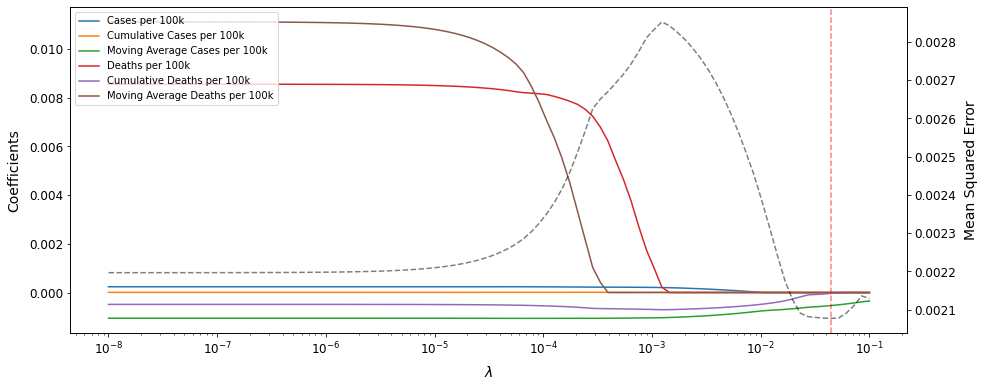

Cases per 100k
----------------------
F: 11.444672341506616
p: 0.0007868241392736062
Lasso: 0.0

Cumulative Cases per 100k
----------------------
F: 48.41217452531342
p: 1.3962937250807489e-11
Lasso: 4.569309315606233e-06

Moving Average Cases per 100k
----------------------
F: 14.151047909465502
p: 0.0001935876202014961
Lasso: -0.0005337617225214679

Deaths per 100k
----------------------
F: 18.33282172320854
p: 2.3184892455280938e-05
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 42.70758223385622
p: 1.9136598614139503e-10
Lasso: -3.443730450175182e-05

Moving Average Deaths per 100k
----------------------
F: 37.230298993357124
p: 2.455956150245064e-09
Lasso: 0.0



In [25]:
dates, fulton_y, fulton_X, feature_labels = feature_extraction("Fulton")
fulton_Fvals, fulton_pvals = f_regression(fulton_X, fulton_y)
fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(fulton_Fvals[i],fulton_pvals[i],fulton_coefs[i]))
    print()

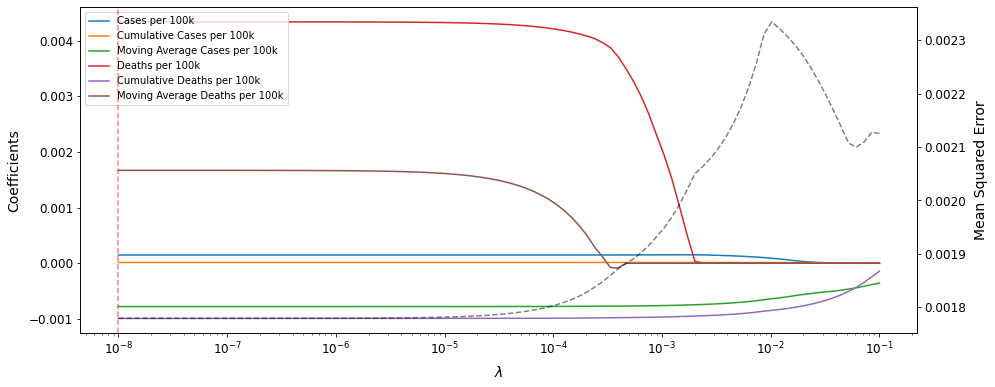

Cases per 100k
----------------------
F: 7.373193362894972
p: 0.006903604804815225
Lasso: 0.00014846927470910676

Cumulative Cases per 100k
----------------------
F: 63.352288028064166
p: 1.7557282761466275e-14
Lasso: 1.4324252635035081e-05

Moving Average Cases per 100k
----------------------
F: 22.32561959981727
p: 3.1791250348164904e-06
Lasso: -0.0007776694983750783

Deaths per 100k
----------------------
F: 2.460814768708583
p: 0.11749916001343504
Lasso: 0.004336304437375355

Cumulative Deaths per 100k
----------------------
F: 26.828110700608697
p: 3.5127614666920447e-07
Lasso: -0.0009900630142748753

Moving Average Deaths per 100k
----------------------
F: 0.11067563291467905
p: 0.7395483755110588
Lasso: 0.0016693682680133637



In [26]:
dates, lowndes_y, lowndes_X, feature_labels = feature_extraction("Lowndes")
lowndes_Fvals, lowndes_pvals = f_regression(lowndes_X, lowndes_y)
lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(lowndes_Fvals[i],lowndes_pvals[i],lowndes_coefs[i]))
    print()

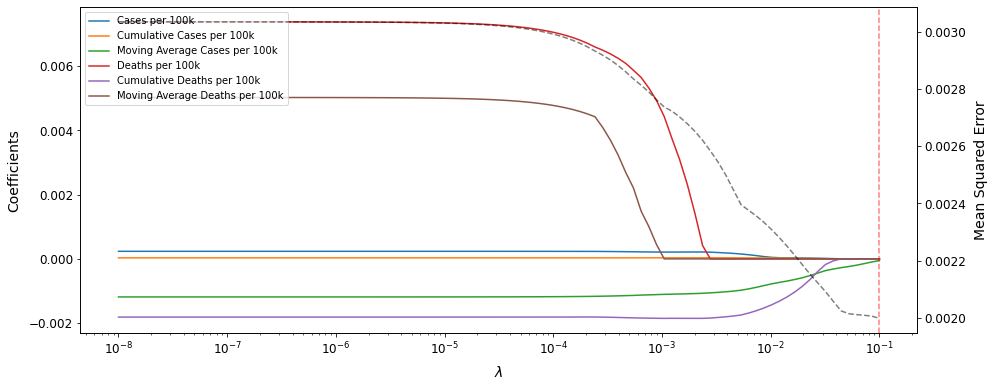

Cases per 100k
----------------------
F: 5.63393519286352
p: 0.01808173540764019
Lasso: 0.0

Cumulative Cases per 100k
----------------------
F: 4.630779959988582
p: 0.03199378043723227
Lasso: 3.2298249997660893e-07

Moving Average Cases per 100k
----------------------
F: 10.030711454301878
p: 0.0016561064140695918
Lasso: -5.30739779085706e-05

Deaths per 100k
----------------------
F: 8.344449342960505
p: 0.004076376811022164
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 3.745809762793769
p: 0.05363584248539416
Lasso: 0.0

Moving Average Deaths per 100k
----------------------
F: 2.5720096131622543
p: 0.10954899906607407
Lasso: 0.0



In [33]:
dates, chatham_y, chatham_X, feature_labels = feature_extraction("Chatham")
chatham_Fvals, chatham_pvals = f_regression(chatham_X, chatham_y)
chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(chatham_Fvals[i],chatham_pvals[i],chatham_coefs[i]))
    print()